In [37]:
import pickle 

from pprint import pprint
import pandas as pd
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sys, os
sys.path.append(os.path.abspath("../../src"))
from visualisation import confusion

In [41]:
DATA_PATH = "../../datasets/bbc/tfidf/"
df = pd.read_csv('../../datasets/bbc/contents.csv', dtype={'label': 'category'})

with open(DATA_PATH+'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

with open(DATA_PATH+'labels_train.pickle', 'rb') as data:
    labels_train = pickle.load(data)

with open(DATA_PATH+'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

with open(DATA_PATH+'labels_test.pickle', 'rb') as data:
    labels_test = pickle.load(data)

In [4]:
print(len(features_train), len(features_test))

1891 334


# Default parameters
Text have high dimensional feature spaces and should usually be linearly separable.  
LinearSVC should therefore give good results.  
cf. Text Categorization with Support Vector Machines: Learning with Many Relevant Features Thorsten Joachims  
et https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

In [11]:
base_model = svm.LinearSVC(random_state=8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9550898203592815

In [5]:
base_model = svm.SVC(random_state=8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9610778443113772

In [6]:
pprint(base_model.get_params())

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


# Random Search

In [29]:
# Random Search
# how much samples inside the margin contribute to the overall error
# large value: smaller margin (misclassification are not allowed), small value: larger margin
C = [.0001, .001, .01, 0.1, 1, 10]
#
gamma = [.00001, .0001, .001, .01, .1, 1, 10, 20, 50, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear', 'rbf', 'poly']
probability = [True]

random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [30]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [16]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'linear', 'gamma': 0.0001, 'C': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9455294778591133


In [17]:
best_svc = random_search.best_estimator_
best_svc

SVC(C=0.1, gamma=0.0001, kernel='linear', probability=True, random_state=8)

In [6]:
# Gridsearch around the best found by RandomSearch
# skipped. (not really necessary, maybe do a finer random search instead)

# Fit best model

In [31]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, gamma=0.0001, kernel='linear', probability=True, random_state=8)

# Performance analysis

In [32]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9624537281861449


In [33]:
svc_pred = best_svc.predict(features_test)

In [34]:
# Test accuracy
# Acc: 0.955
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.9491017964071856


In [35]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))


Classification report
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        76
           1       0.98      0.95      0.96        58
           2       0.95      0.89      0.92        63
           3       0.95      0.97      0.96        77
           4       1.00      0.95      0.97        60

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334



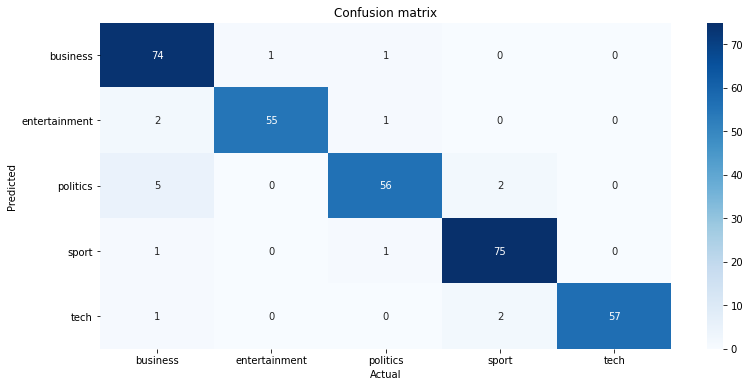

In [42]:
confusion(df, svc_pred, labels_test)

# Sauvegardes

In [ ]:
with open('../models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)

In [ ]:
with open('../../models/bbc/best_rfc.pickle', 'rb') as f:
    best_svc = pickle.load(f)

In [ ]:
df_sc = pd.read_csv("../../models/bbc/models_score.csv")

In [ ]:
row = [
    'SVC',
    accuracy_score(labels_train, best_svc.predict(features_train)),
    accuracy_score(labels_test, best_svc.predict(features_test))
    ]

In [ ]:
df_sc.loc[len(df)] = row

In [ ]:
df_sc.to_csv('../../models/bbc/models_score.csv', index=False)